# EM + Atlas 

In [1]:
from os import listdir
from os.path import isdir, join
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from numpy.linalg import inv, det, norm
from math import sqrt, pi
from functools import partial
#from scipy.spatial.distance import dice

In [31]:
# Normalize array from 0 to 1
def normalize(target_array):
    target_array -= target_array.min()
    normalized_array = 1000 * np.divide(target_array, target_array.max())
    return normalized_array

def show_slice(img, slice_no):
    """
        Inputs: img (nibabel): image name
                slice_no (np slice): np.s_[:, :, 30]
        """
    data = img.get_fdata()
    plt.figure()
    plt.imshow(data[slice_no].T, cmap='gray')
    plt.show()
    
def show_slice_data(data, slice_no):
    plt.imshow(data[slice_no], cmap = "gray")
    plt.show()

# Read nii from path and normalize array from 0 to 1
def read_im(image_path):
    nii_img = nib.load(image_path)
    nii_data = nii_img.get_data()
    return nii_data, nii_img

def calc_dice(segmented_images, groundtruth_images):
    segData = segmented_images + groundtruth_images
    TP_value = np.amax(segmented_images) + np.amax(groundtruth_images)
    TP = (segData == TP_value).sum()  # found a true positive: segmentation result and groundtruth match(both are positive)
    segData_FP = 2. * segmented_images + groundtruth_images
    segData_FN = segmented_images + 2. * groundtruth_images
    FP = (segData_FP == 2 * np.amax(segmented_images)).sum() # found a false positive: segmentation result and groundtruth mismatch
    FN = (segData_FN == 2 * np.amax(groundtruth_images)).sum() # found a false negative: segmentation result and groundtruth mismatch
    return 2*TP/(2*TP+FP+FN)  # according to the definition of DICE similarity score

def dice_similarity(segmented_img, groundtruth_img):
    """
    Extract binary label images for regions  1) CSF (darkest) 3) GM (middle) 2) WM (light)
        Inputs: segmented_img (nibabel): segmented labels nii file
                groundtruth_img (nibabel): groundtruth labels nii file
        Returns: DICE_index (float): Dice similarity score between the two images (nii files)        
    """
    
    CSF_label = 1
    GM_label = 3
    WM_label = 2
    
    segmented_data = segmented_img.get_data().copy()
    groundtruth_data = groundtruth_img.get_data().copy()
    seg_CSF = (segmented_data == CSF_label) * 1
    gt_CSF = (groundtruth_data == CSF_label) * 1
    seg_GM = (segmented_data == GM_label) * 1
    gt_GM = (groundtruth_data == GM_label) * 1
    seg_WM = (segmented_data == WM_label) * 1
    gt_WM = (groundtruth_data == WM_label) * 1
    
    dice_CSF = calc_dice(seg_CSF, gt_CSF)
    dice_GM = calc_dice(seg_GM, gt_GM)
    dice_WM = calc_dice(seg_WM, gt_WM)
    
    
    return dice_CSF, dice_GM, dice_WM

def apply_mask(target_data, gt_data):
    """
    Create mask using groundtruth image and apply it.
    
    Inputs: 
        gt_img: groundtuth mask
        target_img: raw data, apply mask to it
    
    Returns: 
        masked_img: target image with mask applied (background removed)
    """
    
    
    # Create mask: Select pixels higher than 0 in gt and set to 1
    gt_data[gt_data > 0] = 1
    
    # Apply mask
    target_data = np.multiply(target_data, gt_data)
    
    
    return target_data

def gaussian_mixture(features, mean, cov):
    """
    Return Gaussian mixture function for a class.
    
    Inputs:
        features (numpy.ndarray): n by d dimentional array of features of points from feature space, where d is 
                                  is the dimentionality of feature space, n - number of points in the data.
        mean (numpy.ndarray): d-dimentional mean value.
        con (numpy.ndarray): d by d dimentional covariance matrix.
    
    Returns:
        (numpy.ndarray): Gaussian mixture for every point in feature space.
    """
    return np.exp((-0.5/cov)* np.multiply((features - mean),(features - mean)) / (sqrt(2 * pi * cov))

def membership_weight(p0, p1, p2, a0, a1, a2):
    """
    Return membership weights for three classes.
    
    Inputs:
        p0 (numpy.ndarray): mixture component for the 0th class, which is a probability distribution.
        p1 (numpy.ndarray): mixture component for the 1st class, which is a probability distribution.
        p2 (numpy.ndarray): mixture component for the 2nd class, which is a probability distribution.
        a0 (float): the probability of the 0th class.
        a1 (float): the probability for the 1st class.
        a2 (float): the probability for the 2nd class.
        
    Returns:
        (numpy.ndarray): membership weights for each point from the feature space, 
    """
    denominator = (p0 * a0) + (p1 * a1) + (p2 * a2)
    w0 = (p0 * a0) / denominator
    w1 = (p1 * a1) / denominator
    w2 = (p2 * a2) / denominator
    
    return np.stack((w0, w1, w2), axis=1)

def seg_data_to_nii(original_im, y_pred, features_nonzero_row_indicies):
    """
        Inputs: original_im (nibabel): original image nii file
                y_pred (np array): labels for all non-zero points
                features_nonzero_row_indicies (np array): indicies of non-zero points,
                                                          same length as y_pred
        Returns: segment_nii (nibabel): segmented labels nii file        
        """
    original_im_flat = original_im.get_data().copy().flatten()
    segment_im = np.zeros_like(original_im_flat)
    labels = np.copy(y_pred) + 1
    segment_im[features_nonzero_row_indicies] = labels
    segment_im = np.reshape(segment_im, original_im.shape)
    segment_nii = nib.Nifti1Image(segment_im, original_im.affine, original_im.header)
    return segment_nii

def integrate_atlas_nii(original_im, y_pred, features_nonzero, features_nonzero_row_indicies, weights, csf_atlas, 
                           gm_atlas, wm_atlas):
    """
    Transforms segmenation result to nii file, puts correct labels in place.
    The segmentation labels should be: 1) CSF (darkest) 2) GM (middle) 3) WM (light)
    
    Inputs: 
    original_im (nibabel): original image nii file
    y_pred (np array): labels for all non-zero points
    features_nonzero (np array): feature vector of only non-zero intensities
    features_nonzero_row_indicies (np array): indicies of non-zero points,
                                              same length as y_pred

    Returns:
    segment_nii (nibabel): segmented labels nii file        
    """
    
    # Create image with all 3 classes and random labels
    y_pred[np.argwhere(y_pred == 0)] = 3 # change labels from (0->2) to 1->3)
    original_im_flat = original_im.get_data().copy().flatten()
    segment_im = np.zeros_like(original_im_flat)
    segment_im[features_nonzero_row_indicies] = y_pred
    segment_im = np.reshape(segment_im, original_im.shape)
    
    temp_class1_im = np.zeros_like(segment_im)
    temp_class2_im = np.zeros_like(segment_im)
    temp_class3_im = np.zeros_like(segment_im)
    
    #Assign class1 to 1
    temp_class1_im[segment_im == 1] = 1
    #Assign class2 to 2
    temp_class2_im[segment_im == 2] = 1
    #Assign class3 to 1
    temp_class3_im[segment_im == 3] = 1
    
    # Compute DICE between each class to determine which class it belongs to
    dice1 = [calc_dice(temp_class1_im, csf_atlas), calc_dice(temp_class2_im, csf_atlas), 
                                  calc_dice(temp_class3_im, csf_atlas)]
    dice2 = [calc_dice(temp_class1_im, wm_atlas), calc_dice(temp_class2_im, wm_atlas), 
                                  calc_dice(temp_class3_im, wm_atlas)]
    dice3 = [calc_dice(temp_class1_im, gm_atlas), calc_dice(temp_class2_im, gm_atlas), 
                                  calc_dice(temp_class3_im, gm_atlas)]
    csf_to_change = np.argmax(dice1) + 1
    wm_to_change = np.argmax(dice2) + 1
    gm_to_change = np.argmax(dice3) + 1
    
    
    #New y_pred
    y_pred_corrected_labels = np.zeros_like(y_pred)
    #Assign CSF to its correct label
    y_pred_corrected_labels[y_pred == csf_to_change] = CSF_label
    #Assign GM to its correct label
    y_pred_corrected_labels[y_pred == gm_to_change] = GM_label
    #Assign WM to its correct label
    y_pred_corrected_labels[y_pred == wm_to_change] = WM_label

    # Multiply EM weights by Atlas
    
    # Get weights back into original shape
    original_im_flat = original_im.get_data().copy().flatten()
    weight_csf_im = np.zeros_like(original_im_flat)
    weight_gm_im = np.zeros_like(original_im_flat)
    weight_wm_im = np.zeros_like(original_im_flat)
    weight_csf_im[features_nonzero_row_indicies] = weights[:,csf_to_change-1]
    weight_gm_im[features_nonzero_row_indicies] = weights[:,gm_to_change-1]
    weight_wm_im[features_nonzero_row_indicies] = weights[:,wm_to_change-1]
    weight_csf_im = np.reshape(weight_csf_im, original_im.shape)
    weight_gm_im = np.reshape(weight_gm_im, original_im.shape)
    weight_wm_im = np.reshape(weight_wm_im, original_im.shape)
    
    # Multiply weights by each atlas
    csf_probs = weight_csf_im * csf_atlas
    gm_probs = weight_gm_im * gm_atlas
    wm_probs = weight_wm_im * wm_atlas
    
    # Assign GM, WM, CSF to voxel with highest probability
    GM = GM_label * np.nan_to_num((gm_probs > csf_probs) * (gm_probs > wm_probs))
    WM = WM_label * np.nan_to_num((wm_probs > csf_probs) * (wm_probs > gm_probs))
    CSF = CSF_label * np.nan_to_num((csf_probs > wm_probs) * (csf_probs > gm_probs))
    seg_im = GM + WM + CSF
    
    segment_im = np.zeros_like(original_im_flat)
    segment_im = np.reshape(seg_im, original_im.shape)
    segment_nii = nib.Nifti1Image(segment_im, original_im.affine, original_im.header)

    return segment_nii

def seg_correct_labels_to_nii(original_im, y_pred, features_nonzero, features_nonzero_row_indicies, csf_atlas, 
                           gm_atlas, wm_atlas):
    """
    Transforms segmenation result to nii file, puts correct labels in place.
    The segmentation labels should be: 1) CSF (darkest) 2) GM (middle) 3) WM (light)
    
    Inputs: 
    original_im (nibabel): original image nii file
    y_pred (np array): labels for all non-zero points
    features_nonzero (np array): feature vector of only non-zero intensities
    features_nonzero_row_indicies (np array): indicies of non-zero points,
                                              same length as y_pred

    Returns:
    segment_nii (nibabel): segmented labels nii file        
    """
    
    # Create image with all 3 classes and random labels
    y_pred[np.argwhere(y_pred == 0)] = 3 # change labels from (0->2) to 1->3)
    original_im_flat = original_im.get_data().copy().flatten()
    segment_im = np.zeros_like(original_im_flat)
    segment_im[features_nonzero_row_indicies] = y_pred
    segment_im = np.reshape(segment_im, original_im.shape)
    
    temp_class1_im = np.zeros_like(segment_im)
    temp_class2_im = np.zeros_like(segment_im)
    temp_class3_im = np.zeros_like(segment_im)
    
    #Assign class1 to 1
    temp_class1_im[segment_im == 1] = 1
    #Assign class2 to 2
    temp_class2_im[segment_im == 2] = 1
    #Assign class3 to 1
    temp_class3_im[segment_im == 3] = 1
    
    # Compute DICE between each class to determine which class it belongs to
    dice1 = [calc_dice(temp_class1_im, csf_atlas), calc_dice(temp_class2_im, csf_atlas), 
                                  calc_dice(temp_class3_im, csf_atlas)]
    dice2 = [calc_dice(temp_class1_im, wm_atlas), calc_dice(temp_class2_im, wm_atlas), 
                                  calc_dice(temp_class3_im, wm_atlas)]
    dice3 = [calc_dice(temp_class1_im, gm_atlas), calc_dice(temp_class2_im, gm_atlas), 
                                  calc_dice(temp_class3_im, gm_atlas)]
    csf_to_change = np.argmax(dice1) + 1
    wm_to_change = np.argmax(dice2) + 1
    gm_to_change = np.argmax(dice3) + 1
    
    
    #New y_pred
    y_pred_corrected_labels = np.zeros_like(y_pred)
    #Assign CSF to its correct label
    y_pred_corrected_labels[y_pred == csf_to_change] = CSF_label
    #Assign GM to its correct label
    y_pred_corrected_labels[y_pred == gm_to_change] = GM_label
    #Assign WM to its correct label
    y_pred_corrected_labels[y_pred == wm_to_change] = WM_label

    original_im_flat = original_im.get_data().copy().flatten()
    segment_im = np.zeros_like(original_im_flat)
    labels = np.copy(y_pred_corrected_labels)
    segment_im[features_nonzero_row_indicies] = labels
    segment_im = np.reshape(segment_im, original_im.shape)
    segment_nii = nib.Nifti1Image(segment_im, original_im.affine, original_im.header)

    return segment_nii

def get_log_likelihood(class_dist, gauss_density):
    """
    Return loglikelihood.
    
    Parameters:
        class_dist: iterable with class distributions.
        gauss_density: iterable with Gaussian densities for each class.
    
    Returns:
        float: log likelihood value. 
    """
    for index, alpha in enumerate(class_dist):
        if index == 0:
            total_sum = alpha * gauss_density[index]
        else:
            total_sum += alpha * gauss_density[index]
    
    return np.sum(np.log(total_sum))

# Data Preparation

In [4]:
# put either 'mni' or 'our' (made from provided test images)
use_atlas = 'our'

MAX_STEPS = 5
min_change = 0.01
# select initial classes for each point, it can be either 'kmeans' or 'random'
class_init = 'atlas' 

if use_atlas == 'our':
    # Path to test image
    test_img_path = "./test-set/testing-images/"
    atlas_path = "./test-set/registration-results/our_atlases/"
    result_path = "./test-set/segmentation-results/our-EM-atlas-segmentation/"
    gt_path = "./test-set/testing-labels/"
    mask_path = "./test-set/testing-mask/"
    
    out_dice_path = 'our_EM_atlas_dice.csv'
    
elif use_atlas == 'mni':
    # Path to test image
    test_img_path = "./test-set/testing-images/"
    atlas_path = "./test-set/registration-results/mni_atlases/"
    result_path = "./test-set/segmentation-results/mni-EM-atlas-segmentation/"
    gt_path = "./test-set/testing-labels/"
    mask_path = "./test-set/testing-mask/"
    
    out_dice_path = 'mni_EM_atlas_dice.csv'
else:
    raise ValueError("our_atlas values should be either mni' or 'our'")

onlydirs = [f[:-7] for f in listdir(test_img_path)]

all_dice = np.zeros((len(onlydirs),3))

# Key the labels already in the files
CSF_label = 1
GM_label = 3
WM_label = 2

Means: 442.00018310546875, 1381.1590576171875, 1018.3395385742188
COV: 79013.2421875, 114038.3203125, 114038.3203125
Atlas class distribution 0.03640681310779059, 0.4282315854606875, 0.5353616014315219
y pred: [0 1 2]
Atlas Image
class counts: [ 33193 465714 697023]
Step 0 class distribution 0.02775496893630898, 0.38941576848143283, 0.5828292625822582
Means: 655.4379537854367, 1565.2755811506634, 901.0619850421006
COV: 120774.78890127437, 141986.50481626063, 141986.50481626063
-8814988.0
-8876609.0
********************************************************************
Step 0
Distribution change 61621.000000
0.02775496893630898 0.38941576848143283 0.5828292625822582


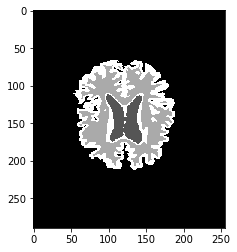

y pred: [1 2]
Atlas Image
class counts: [449719 746211]
Step 1 class distribution 0.37604123987189886, 0.6239587601281011, 8.361693410149424e-07
Means: 46.097816636610865, 941.5371041166641, 655464192.0
COV: 36737.66873981308, 214951.79348468463, 214951.79348468463
-8876609.0
-9488546.0
********************************************************************
Step 1
Distribution change 611937.000000
0.37604123987189886 0.6239587601281011 8.361693410149424e-07


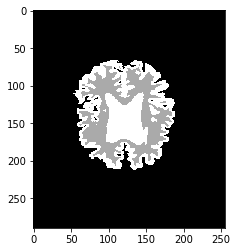

y pred: [0 1]
Atlas Image
class counts: [  32612 1163318]
Step 2 class distribution 0.0272691545491793, 0.9727308454508207, 8.361693410149424e-07
Means: 278.7415368575984, 1177.0791615018422, 3.1596341614203993e-06
COV: 13095.011897461056, 131475.85449206494, 131475.85449206494
-9488546.0
-8805097.0
********************************************************************
Step 2
Distribution change 683449.000000
0.0272691545491793 0.9727308454508207 8.361693410149424e-07


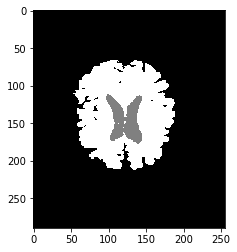

y pred: [0 1]
Atlas Image
class counts: [  33030 1162900]
Step 3 class distribution 0.027618673333723545, 0.9723813266662764, 8.361693410149424e-07
Means: 224.95414774447474, 1179.0049290566687, 0.0
COV: 7852.823251589464, 132840.28571330296, 132840.28571330296


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:100: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in true_divide


-8805097.0
nan
********************************************************************
Step 3
Distribution change nan
0.027618673333723545 0.9723813266662764 8.361693410149424e-07


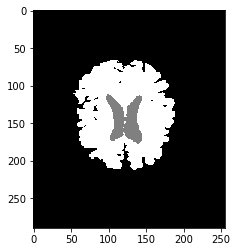

y pred: [0]
Atlas Image
class counts: [1195930]
Step 4 class distribution 1.0, 8.361693410149424e-07, 8.361693410149424e-07
Means: nan, nan, nan
COV: nan, nan, nan
nan
nan
********************************************************************
Step 4
Distribution change nan
1.0 8.361693410149424e-07 8.361693410149424e-07


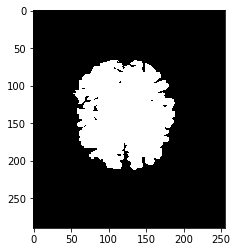

Loop stopped


In [48]:
for i, f in enumerate(onlydirs):
    if i==0:
        # Load all data for EM algorithm
        test_data, test_img = read_im(join(test_img_path,f+'.nii.gz'))
        #test_data = normalize(test_data)
        GM_atlas, _ = read_im(join(atlas_path, f,'gm','result.nii.gz'))
        WM_atlas, _ = read_im(join(atlas_path, f,'wm','result.nii.gz'))
        CSF_atlas, _ = read_im(join(atlas_path, f,'csf','result.nii.gz'))
        _, groundtruth_img = read_im(join(gt_path,f+"_3C.nii.gz"))
        mask_data, _ = read_im(join(mask_path,f+"_1C.nii.gz"))
        # Apply mask from mask image
        test_masked = np.multiply(mask_data, test_data)
        # Pre-process feature vector to remove background points from algorithm
        # and save those indicies to add back

        features = test_masked.copy().flatten()
        mask_data = mask_data.copy().flatten() 
        features_nonzero_row_indicies = np.nonzero(mask_data)

        features_nonzero = features[features_nonzero_row_indicies]

        if class_init == 'kmeans':
            features_nonzero_reshaped = features_nonzero.reshape(-1, 1)
            kmeans = KMeans(n_clusters=3, random_state=0, init='k-means++')\
            .fit(features_nonzero_reshaped)
            y_pred = kmeans.predict(features_nonzero_reshaped)
            centroids = kmeans.cluster_centers_

            class0 = features_nonzero[np.argwhere(y_pred == 0)[:,0],:]
            class1 = features_nonzero[np.argwhere(y_pred == 1)[:,0],:]
            class2 = features_nonzero[np.argwhere(y_pred == 2)[:,0],:]

            # Compute mean and variance of each class
            mean0 = np.mean(class0, axis = 0)
            mean1 = np.mean(class1, axis = 0)
            mean2 = np.mean(class2, axis = 0)
            cov0 = np.cov(class0, rowvar = False)
            cov1 = np.cov(class1, rowvar = False)
            cov2 = np.cov(class2, rowvar = False)

            # Class distribution
            a0 = class0.shape[0] / features_nonzero_reshaped.shape[0]
            a1 = class1.shape[0] / features_nonzero_reshaped.shape[0]
            a2 = class2.shape[0] / features_nonzero_reshaped.shape[0]
            print("Initialization")
            print(f"Means: {mean0}, {mean1}, {mean2}")
            print(f"SD: {cov0}, {cov1}, {cov2}")
            print(f"a's: {a0}, {a1}, {a2}")
        elif class_init == 'atlas':
            GM_atlas_flat = GM_atlas.flatten()
            WM_atlas_flat = WM_atlas.flatten()
            CSF_atlas_flat = CSF_atlas.flatten()

            # row index shifted by +1 will correspond to tissue labels from ground-truth
            features_nonzero_pred = np.array((CSF_atlas_flat[features_nonzero_row_indicies],
                                              WM_atlas_flat[features_nonzero_row_indicies],
                                              GM_atlas_flat[features_nonzero_row_indicies]))
            y_pred = np.argmax(features_nonzero_pred, axis=0)

            class0 = features_nonzero[np.argwhere(y_pred == 0)]
            class1 = features_nonzero[np.argwhere(y_pred == 1)]
            class2 = features_nonzero[np.argwhere(y_pred == 2)]

            # Compute mean and variance of each class
            mean0 = np.mean(class0)
            mean1 = np.mean(class1)
            mean2 = np.mean(class2)
            print(f"Means: {mean0}, {mean1}, {mean2}")
            cov0 = np.var(class0)
            cov1 = np.var(class1)
            cov2 = np.var(class2)
            print(f"COV: {cov0}, {cov1}, {cov1}")

            # Class distribution
            a0 = class0.shape[0] / features_nonzero.shape[0]
            a1 = class1.shape[0] / features_nonzero.shape[0]
            a2 = class2.shape[0] / features_nonzero.shape[0]
            print('Atlas class distribution {0}, {1}, {2}'.format(a0, a1, a2))
        else:
            raise ValueError("Incorrect class_init value, shoulb be one from ('kmeans', 'random')")

        # Compute Gaussian mixture model for each point
        p0 = gaussian_mixture(features_nonzero,  mean = mean0, cov = cov0)
        p1 = gaussian_mixture(features_nonzero,  mean = mean1, cov = cov1)
        p2 = gaussian_mixture(features_nonzero,  mean = mean2, cov = cov2)

        # Compute membership weight for each point
        weights = membership_weight(p0, p1, p2, a0, a1, a2)

        log_likelihood = get_log_likelihood((a0, a1, a2), (p0, p1, p2))

        n_steps = 0

        while True:
            # Maximization step: Use that classification to reestimate the parameters
            y_pred = np.argmax(weights, axis=1)
            print(f"y pred: {np.unique(y_pred)}")

            # Show Atlas Image
            print("Atlas Image")
            segment_img = seg_data_to_nii(test_img, y_pred, features_nonzero_row_indicies)

            # Class distribution
            _, counts = np.unique(y_pred, return_counts=True)
            print(f"class counts: {counts}")

            if len(counts) == 2:
                counts = [counts[0], counts[1], 1]
            elif len(counts) == 1:
                counts = [counts[0], 1, 1]

            a0 = counts[0] / len(features_nonzero)
            a1 = counts[1] / len(features_nonzero)
            a2 = counts[2] / len(features_nonzero)
            print(f'Step {n_steps} class distribution {a0}, {a1}, {a2}')

            # Calculate mean and covariance for new classes
            mean0 = (1/counts[0]) * (weights[:,0] @ features_nonzero)
            mean1 = (1/counts[1]) * (weights[:,1] @ features_nonzero)
            mean2 = (1/counts[2]) * (weights[:,2] @ features_nonzero)
            print(f"Means: {mean0}, {mean1}, {mean2}")

            cov0 = (1/counts[0]) * (weights[:,0] @ np.multiply((features_nonzero - mean0) ,(features_nonzero - mean0)))
            cov1 = (1/counts[1]) * (weights[:,1] @ np.multiply((features_nonzero - mean1) ,(features_nonzero - mean1)))
            cov2 = (1/counts[2]) * (weights[:,2] @ np.multiply((features_nonzero - mean2) ,(features_nonzero - mean2)))
            print(f"COV: {cov0}, {cov1}, {cov1}")

            # Expectation step: Recompute labels for all the dataset given the current cluster parameters.
            # Compute Gaussian mixture model for each point
            p0 = gaussian_mixture(features_nonzero,  mean = mean0, cov = cov0)
            p1 = gaussian_mixture(features_nonzero,  mean = mean1, cov = cov1)
            p2 = gaussian_mixture(features_nonzero,  mean = mean2, cov = cov2)

            # Compute membership weight for each point
            weights = membership_weight(p0, p1, p2, a0, a1, a2)

            segment_img = seg_data_to_nii(test_img, y_pred, features_nonzero_row_indicies)

            log_likelihood_new = get_log_likelihood((a0, a1, a2), (p0, p1, p2))

            print(log_likelihood)
            print(log_likelihood_new)

            log_change = abs(log_likelihood - log_likelihood_new)

            print("********************************************************************")
            print("Step %d" % n_steps)
            print("Distribution change %f" % log_change)
            print(a0, a1, a2)
            show_slice(segment_img, np.s_[:, :, 150])

            n_steps += 1

            # check whether we reached desired precision or max number of steps
            if (n_steps >= MAX_STEPS): #or (dist_change <= min_change):
                print("Loop stopped")
                break
            else:
                log_likelihood = log_likelihood_new

In [49]:
segment_nii_atlas = integrate_atlas_nii(test_img, y_pred, features_nonzero, 
                       features_nonzero_row_indicies, weights, CSF_atlas, 
                       GM_atlas, WM_atlas)

# Calculate DICE
all_dice[i,0], all_dice[i,1], all_dice[i,2] = dice_similarity(segment_nii_atlas, groundtruth_img)

    # Make directory to save result seg
#     new_dir = join(result_path,f)
#     os.mkdir(new_dir)
#     nib.save(segment_nii_atlas, join(new_dir,'atlas_EM_seg.nii.gz'))

        
# Save DICE values
with open(out_dice_path, 'w+') as out_f:
    out_f.write('img,csf,gm,wm,\n')
    for index, row in enumerate(all_dice): 
        out_f.write(onlydirs[index] + ',' + ','.join(str(j) for j in row) + ',\n')
        log_likelihood = get_log_likelihood((a0, a1, a2), (p0, p1, p2))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:216: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:217: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:218: RuntimeWarning: invalid value encountered in greater
